## Data and Statistical Calibration (Indirect Inference) on Model

### KLLN

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import seaborn as sns

import requests, zipfile, io
from pandas import ExcelWriter
from pandas import ExcelFile
from fredapi import Fred

import statistics as stats
from scipy import interpolate
from scipy.optimize import curve_fit

from itertools import product
import time

%matplotlib inline

In [2]:
# Instantiate Fred class as "fred", with personal own api_key 
# It can be registered through https://research.stlouisfed.org by searching api key
fred = Fred(api_key = 'cd6992c5ce004b0b4493fe2cf6c3fdab')

In [3]:
df = {}

In [4]:
#get data from Assets tab in Lucas-Nicolini excel file
data_LN_data = \
        pd.read_excel('Calibration_data.xlsx', 'data_consolidated')

In [5]:
# Store lists of data series and KEYs into dictionary df
df['Dates'] = data_LN_data['years'].tolist()
df['T-Bill Rate (3-month, annual)'] = (data_LN_data['tbills3m']/100.).tolist()
df['NewM1/GDP'] = (data_LN_data['new_m1']/100.).tolist()

# inflation
inflation = fred.get_series('CPIAUCNS', frequency='a')
inflation = inflation.reset_index()
inflation.columns = ['Dates', 'CPI (seasonal)']
inflation = inflation.set_index(inflation['Dates'])
start_year = '1915'
stop_year = '2016' 
inflation = inflation['CPI (seasonal)']/inflation['CPI (seasonal)'].shift(1) - 1

df['Inflation (CPI, raw)'] = inflation.loc[start_year+'-01-01':stop_year+'-01-01']

obslength = []
keys = []

for list_idx, list_key in enumerate(df):
    list_length = len(df[list_key])
    print(list_idx, list_key, "> Observations:", list_length)
    obslength.append(list_length)
    keys.append(list_key)
obslength_min = min(obslength)
print("Shortest data series is %s with data length of %i" %(keys[obslength==obslength_min], obslength_min))


0 Dates > Observations: 102
1 T-Bill Rate (3-month, annual) > Observations: 102
2 NewM1/GDP > Observations: 102
3 Inflation (CPI, raw) > Observations: 102
Shortest data series is Dates with data length of 102


In [6]:
# Truncate longer series to have the same length of: obslength_min
for list_idx, list_key in enumerate(df):
    df[list_key] = df[list_key][0:obslength_min]

In [7]:
# Convert df to Pandas dataframe
d = pd.DataFrame(df)
d = d.set_index(d['Dates'])

In [8]:
d

,Dates,"T-Bill Rate (3-month, annual)",NewM1/GDP,"Inflation (CPI, raw)"
Dates,,,,
1915,1915,0.0285,0.322164,0.009085
1916,1916,0.0325,0.295371,0.076672
1917,1917,0.0462,0.284928,0.178443
1918,1918,0.0419,0.248897,0.172865
1919,1919,0.0437,0.276148,0.152307
...,...,...,...,...
2012,2012,0.0009,0.416954,0.020694
2013,2013,NaN,0.428727,0.014648
2014,2014,NaN,0.437827,0.016222


## This notebook (below) uses truncated sample (1980-2007)


In [9]:
# Truncate data window
date_truncate_start = '1983' 
date_truncate_stop = '2007'

dcut = d.loc[date_truncate_start:date_truncate_stop]

### Visualization of data 

<AxesSubplot:xlabel='Dates'>

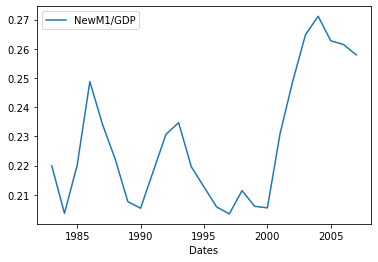

In [10]:
# M/PY using M1 (sweep adjusted) data for M, nominal GDP for PY
dcut.plot(y='NewM1/GDP')

<AxesSubplot:xlabel='Dates'>

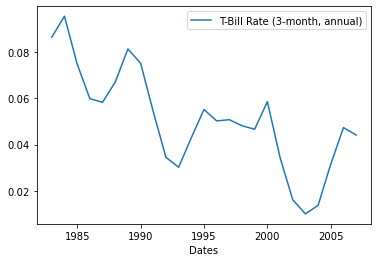

In [11]:
# T-Bill Rate (3-month, annual) 
dcut.plot(y='T-Bill Rate (3-month, annual)')

<AxesSubplot:xlabel='T-Bill Rate (3-month, annual)', ylabel='NewM1/GDP'>

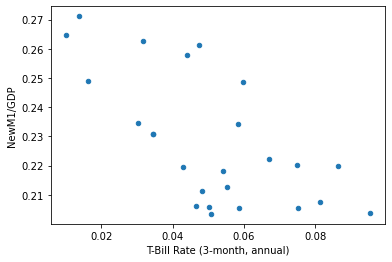

In [12]:
# Scatter plot M/PY vs. Federal Funds Rate
dcut.plot(x='T-Bill Rate (3-month, annual)', y='NewM1/GDP', kind='scatter')

<AxesSubplot:xlabel='T-Bill Rate (3-month, annual)', ylabel='Inflation (CPI, raw)'>

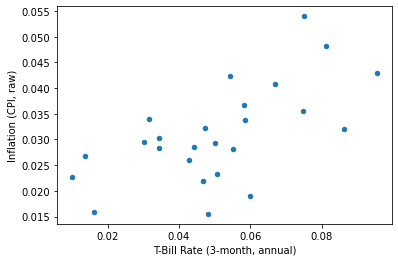

In [13]:
# Scatter plot Federal Funds Rate vs. inflation
dcut.plot(x='T-Bill Rate (3-month, annual)', y='Inflation (CPI, raw)', kind='scatter')

In [14]:
# Truncated sample (1980-2007) stats
dcut_mean = dcut.mean().to_frame()
dcut_mean.columns = ["sample mean"]
dcut_mean

,sample mean
Dates,1995.000000
"T-Bill Rate (3-month, annual)",0.050640
NewM1/GDP,0.228289
"Inflation (CPI, raw)",0.031108


In [15]:
T_bill_mean = 0.050640
τ_mean = 0.031108
#Use Fisher relation to back out the discount factor
β_data= (1.0+τ_mean)/(1.0+T_bill_mean)
print(β_data)

0.9814094266351937


### Visualization tool

In [16]:

def func(x, a, b, c):
    return a*np.exp(-b * x) + c 

def money_func_fit(x, y):
    data = np.asarray(sorted(zip(x,y)))
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    return fitted_func

def markup_func_fit(x,y):
    data = np.asarray(sorted(zip(x,y)))
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    return fitted_func

def visualization(x = dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                  y = dcut['NewM1/GDP'].tolist(),\
                  x_label = 'T-Bill Rate (3-month, annual)',\
                  y_label = 'NewM1/GDP',\
                  model_x = np.linspace(0.0,0.0,1),\
                  model_y = np.linspace(0.0,0.0,1)
                 ):
    data = np.asarray(sorted(zip(x,y)))
   
    i_set = np.linspace(data[:,0].min(), data[:,0].max())
    i_mean = 0.050640
    

    if y_label == 'NewM1/GDP':
        popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    else:
        popt, pcov = curve_fit(func, x, y, bounds=(0.001, 10.0))
    fitted_func = func(i_set, *popt)
    if y_label == 'NewM1/GDP':
        plt.scatter(x, y, label='Data: 1983-2007')
        plt.plot(i_set, fitted_func, '--', color='r', label='Fitted spline')
        plt.plot(model_x, model_y, '-g', label="Model")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(0.0, 0.11)
        plt.ylim(0.15, 0.3)
        plt.legend()
        plt.show()
    else:
        plt.scatter(x, y, label='Data: 1983-2007')
        plt.plot(i_set, fitted_func, '--', color='r', label='Fitted spline')
        plt.plot(model_x, model_y, '-g', label="Model")
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xlim(0.0, 0.11)
        plt.ylim(1.0, 1.6)
        plt.legend()
        plt.show()    
    return fitted_func


In [17]:
y = dcut['NewM1/GDP'].tolist()
x = dcut['T-Bill Rate (3-month, annual)'].tolist()
data = np.asarray(sorted(zip(x,y)))
L_fit = interpolate.splrep(data[:,0], data[:,1], s=3)

# Scatter plot data
# Plot fitted spline function 
i_set = np.linspace(data[:,0].min(), data[:,0].max())
L_set = interpolate.splev(i_set, L_fit, der=0)
M1_fit_target=L_set
# Plot point where data at mean
i_mean = np.asarray(x).mean()
L_mean = interpolate.splev(i_mean, L_fit, der=0)
# L_mean = df_comb2['NewM1/GDP'].mean()
L_mean_slope = interpolate.splev(i_mean, L_fit, der=1)

Elasticity_L_i = L_mean_slope*i_mean/L_mean
print("L_mean = %6.4f" %(L_mean))
print("i_mean = %6.4f" %(i_mean))
print("Slope = %6.4f" %(L_mean_slope))
print("Elasticity of M1/GDP w.r.t. Nominal Interest Rate = %6.4f" %(Elasticity_L_i) )

L_mean = 0.2243
i_mean = 0.0506
Slope = -0.5389
Elasticity of M1/GDP w.r.t. Nominal Interest Rate = -0.1216


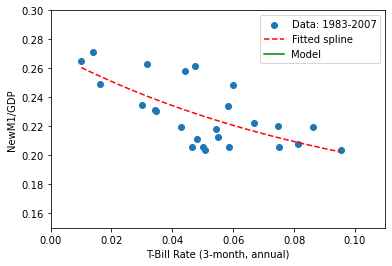

In [18]:
M1_GDP_fit_target =visualization(x = dcut['T-Bill Rate (3-month, annual)'].tolist(),\
                  y = dcut['NewM1/GDP'].tolist(),\
                  x_label = 'T-Bill Rate (3-month, annual)',\
                  y_label = 'NewM1/GDP',\
                  model_x = np.linspace(0.0,0.0,50),\
                  model_y = np.linspace(0.0,0.0,50))

### Store targets for calibration below

In [19]:
M1_GDP_target = M1_GDP_fit_target

In [20]:
def ols(x, y):
    # Linear best fit:
    deg = 1 # OLS for linear best fit equation
    bols = np.polyfit(x, y, deg, rcond=None, full=False)
    y = bols[1] + bols[0]*x
    return bols

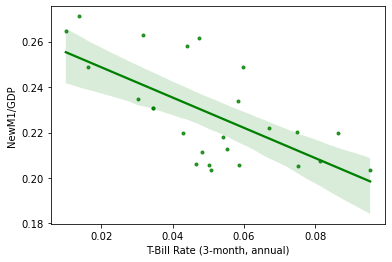

In [21]:
# Data
i_data = dcut['T-Bill Rate (3-month, annual)']
M1_GDP_data = dcut['NewM1/GDP']

plt.figure()
ax2 = sns.regplot(x=i_data, y=M1_GDP_data, 
                 data=None, 
                 fit_reg=True, 
                 x_estimator=None, 
                 marker=".", color="g") 

In [22]:
bols = ols(i_data, M1_GDP_data)
print("\nNow we approximate correlation: \n")
print("\t\tLinear Best Fit (Slope, Intercept) = ", str(bols), "\n")
    


Now we approximate correlation: 

		Linear Best Fit (Slope, Intercept) =  [-0.66693817  0.26206226] 



In [23]:
from datetime import date

today = date.today()

## Calibration 

In [24]:
import bcw_bj as klln

In [25]:
σ_DM_range = np.linspace(0.32, 0.32, 1)  
Ubar_CM_range = np.linspace(1.8, 1.8, 1)
α_1_range = np.linspace(0.0475,0.0475, 1)


#create a for-loop parameter value table
KLLN_class = np.array( [klln.baseline_mod(β=β_data, σ_CM=1.0, σ_DM=i, α_1=j,Ubar_CM=k,n=0.65,τ_min=β_data-1+1e-2,τ_max=0.08) \
                            for (i, j, k) in product(σ_DM_range,\
                                                        α_1_range,\
                                                        Ubar_CM_range)]) 
    

print(KLLN_class.size)


1


In [26]:
print(β_data)

0.9814094266351937


* each index corresponds to a class with 1 possible combination of parameter values in the for-loop parameter table 

In [27]:
def L(M1_GDP_target):
    """distance function between model simulated stat vs. spline-fitted data target"""
    
    L_diff = np.zeros(KLLN_class.size)
    
    for idx, x in enumerate(KLLN_class):
        # each idx is a particular class instantiation with particular 
        # parameter values in the parameter for-loop table
        
        # get SME result (dictionary)
        # note: this solver has equilibrium conditions check
        z_guess, i_guess = 0.4, 0.01
        result = KLLN_class[idx].SME_stat(z_guess, i_guess)
        
        # extract model implied M/PY array 
        # note: model M/P = z, and Y = CM consumption + total DM consumption
        mpy_grid = result['stat_grid']['mpy_star']

        i_FFR_grid = result['stat_grid']['FFR']
        
        w_mpy = 1.0/(stats.variance(M1_GDP_target))

        diff_M1_GDP =  np.abs(mpy_grid - M1_GDP_target) 
       
        L_diff_func = np.sum( w_mpy*(diff_M1_GDP)**2.0 )
    
        L_diff[idx] = L_diff_func.min()

        print(KLLN_class[idx].σ_DM)
        print(KLLN_class[idx].α_1)
        print(KLLN_class[idx].Ubar_CM)
               
    L_diff_min = L_diff[L_diff.argmin()]
    # get the corresponding class instantiation 
    KLLN_model = KLLN_class[L_diff.argmin()]
    # pick the corresponding value with minimum distance between model and target    
    model_result = KLLN_model.SME_stat(z_guess, i_guess)
    
    M1_GDP_star = model_result['stat_grid']['mpy_star']
    τ_mean = 0.031108
    z_mean, i_mean = KLLN_model.solve_z_i(z_guess, i_guess, τ_mean)  
    markup_star = KLLN_model.markup_func(z_mean, i_mean, τ_mean) 
    mpy_star = z_mean/(KLLN_model.x_star+ KLLN_model.Total_q_func(z_mean, i_mean,τ_mean))
    i_policy_grid = model_result['stat_grid']['FFR']
    τ_grid = [τ_mean-1e-5, τ_mean, τ_mean+1e-5]
    mpy_star_grid =[]
    i_grid=[]
    for τ in τ_grid:
        z, i = KLLN_model.solve_z_i(z_guess, i_guess, τ)
        mpy_star = z/(KLLN_model.x_star+ KLLN_model.Total_q_func(z, i,τ))
        mpy_star_grid.append(mpy_star)
        i_grid.append(i)
    M1_elasticity = (i_grid[1]/mpy_star_grid[1])*((mpy_star_grid[-1]-mpy_star_grid[0])/(i_grid[-1]-i_grid[0]))
    
    
    #implied parameter values that achieve the shortest distance between model and target
    σ_DM = KLLN_model.σ_DM
    σ_CM = KLLN_model.σ_CM
    α_1 = KLLN_model.α_1
    Ubar_CM = KLLN_model.Ubar_CM    
    
    return  M1_GDP_star, M1_elasticity , markup_star, mpy_star,\
            i_policy_grid, σ_DM, σ_CM, α_1, Ubar_CM,\
            L_diff_min, KLLN_model
       

In [28]:
tic = time.time()
M1_GDP_star, M1_elasticity, markup_star, mpy_star,i_policy_grid, σ_DM, σ_CM, α_1, Ubar_CM,\
            L_diff_min, KLLN_model = L(M1_GDP_target)           
toc = time.time()-tic
print(toc, "seconds")

Elapsed time of solving SME: 61.50506067276001 seconds
0.32
0.0475
1.8
Elapsed time of solving SME: 66.01739525794983 seconds
129.2384853363037 seconds


In [29]:
rowlabels = ["$\sigma_{DM}$", "B (Ubar_CM)",\
             "$α_1$"]

model_para = [ σ_DM, σ_DM, α_1]
model_para_table = { "Calibrated parameters": rowlabels,
                     "Model (Avg)": model_para                
                   }
# Create dataframe
df_model_parameter = pd.DataFrame(data=model_para_table)
df_model_parameter

,Calibrated parameters,Model (Avg)
0,$\sigma_{DM}$,0.3200
1,B (Ubar_CM),0.3200
2,$α_1$,0.0475


In [30]:
markup_star 

1.249279243808855

In [31]:
rowlabels = ["$μ$","$M/PY$","$M/PY$ elasticity"]

model_para = [α_1,Ubar_CM,σ_DM]
model_para_table = { "Notation": rowlabels,  
                     "Model": [np.round(markup_star, 4),np.round(mpy_star, 4),np.round(M1_elasticity, 4)],
                     "Data": [1.3 , np.round(L_mean, 4),np.round(Elasticity_L_i, 4)],
                     "Calibration Paramters": ["$α_1$", "B (Ubar_CM)","$\sigma_{DM}$"],
                     "Parameter Value":model_para
                   }
# Create dataframe
df_model_data = pd.DataFrame(data=model_para_table)
df_model_data

,Notation,Model,Data,Calibration Paramters,Parameter Value
0,$μ$,1.2493,1.3000,$α_1$,0.0475
1,$M/PY$,0.2291,0.2243,B (Ubar_CM),1.8000
2,$M/PY$ elasticity,-0.1254,-0.1216,$\sigma_{DM}$,0.3200


In [32]:
x_data=dcut['T-Bill Rate (3-month, annual)'].tolist()
y_data=dcut['NewM1/GDP'].tolist()
data = np.asarray(sorted(zip(x_data,y_data)))
i_set = np.linspace(data[:,0].min(), data[:,0].max())
money_fitted_func = money_func_fit(x_data,y_data)

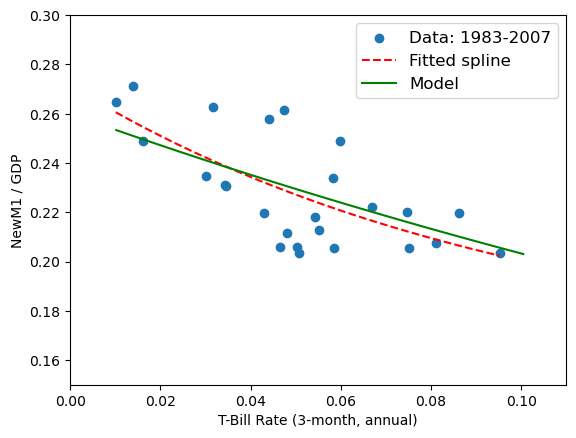

In [33]:
plt.style.use(style='default')
plt.scatter(x_data, y_data, label="Data: 1983-2007")
plt.plot(i_set, money_fitted_func, '--', color='r', label='Fitted spline')
plt.plot(i_policy_grid, M1_GDP_star, '-', color='green', label="Model")
plt.xlabel('T-Bill Rate (3-month, annual)')
plt.ylabel('NewM1 / GDP')
plt.xlim(0.0, 0.11)
plt.ylim(0.15, 0.3)
plt.legend(fontsize=12)
plt.savefig("m1_gdp_model_fit.png", dpi=800)


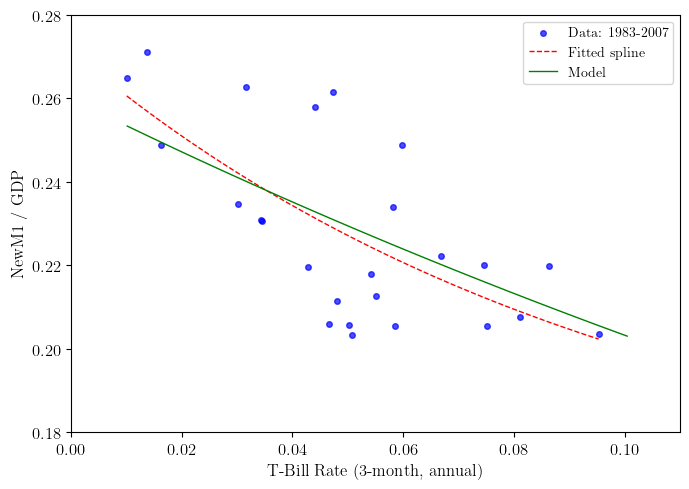

In [41]:
# Update matplotlib parameters for a similar style without using LaTeX
plt.rcParams.update({
    "text.usetex": True,  # Disable LaTeX as it's not available
    "font.family": "serif",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "lines.linewidth": 1,
    "lines.markersize": 4,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})

# Create the plot again
plt.figure(figsize=(7, 5))
plt.scatter(x_data, y_data, label="Data: 1983-2007", color="blue", alpha=0.7)
plt.plot(i_set, money_fitted_func, '--', color='red', label="Fitted spline")
plt.plot(i_policy_grid, M1_GDP_star, '-', color='green', label="Model")
plt.xlabel("T-Bill Rate (3-month, annual)")
plt.ylabel("NewM1 / GDP")
plt.xlim(0.0, 0.11)
plt.ylim(0.18, 0.28)
plt.legend(loc='upper right', fontsize=10, frameon=True)
#plt.title("Calibration and money demand data")

# Save and display the plot
plt.tight_layout()
output_path = "m1_gdp_model_fit.png"
plt.savefig(output_path, dpi=800)
plt.show()